This file is to try SBI_SGM 

And I train model with a general connectome.


# import and define

In [2]:
import sys
sys.path.append("../mypkg")
# There is some pkgs incompatible (not readlly know why),
# make sure you input `mkl` at the beginning of the file
# to eliminate the incompatible error
import mkl 

In [3]:
import scipy
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from easydict import EasyDict as edict
from pathlib import Path
from tqdm import trange, tqdm
from functools import partial

In [4]:
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

In [6]:
from constants import RES_ROOT, FIG_ROOT, DATA_ROOT
from sgm.sbi_sgm import SBI_SGM
from sgm.sgm import SGM
from utils.misc import load_pkl

# Load real data 

I prepare an example meg data under `data/example_meg.pkl`

it contains:

- sc_mat: sc matrix
- dist_mat: distance matrix
- ts: the original meg time series
- fc: the fc matrix from ts
- psd: the PSD from ts
- freqs: The freqs pts corresponding to psd
- fs: sampling freq (in Hz)

In [7]:
meg_example = load_pkl(DATA_ROOT/"example_meg.pkl");
sc_mat = meg_example.sc_mat
dist_mat = meg_example.dist_mat
freqs = meg_example.freqs
fc = meg_example.fc
psd = meg_example.psd
ts = meg_example.ts;

Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM_clean/notebooks/../mypkg/../data/example_meg.pkl


In [10]:
# initialize the sgmmodel class

sgmmodel = SGM(C=sc_mat, D=dist_mat, freqs=freqs, verbose=2);

2024-02-29 17:14:32,199 - sgm.sgm - INFO - Num of ROI is 68.


# Fitting with `SBI`

In [12]:
"""
initial the SBI_SGM class
sgmmodel: SGM class.
save_folder: the folder you want to save the results to, str or bool, if True, it generates a default folder
verbose: more output or not. if you feel the output info is annoying, set verbose=False
params: all other parameters
  - num_round: the num of rounds to training sbi
  - num_prior_sps: the num of sps used to train SBI, 
                   10,000 is a good starting point for single round training
                   1000 is a good starting point for num_round=3
  - noise_sd: the noise sd added to SGM output, 
These three are most inferential params in SBI_SGM
  - fit_target: can be fc, psd or both.
other params for fitting sbi, refer to source file
"""
sbi_sgm = SBI_SGM(sgmmodel, 
                  save_folder="sbisgm_meg", 
                  verbose=1, params={
                      "fit_target":"both", 
                      "noise_sd": 0.2, 
                      "num_prior_sps":500, 
                      "num_round":3})

In [13]:
"""
You add the real data to the fitting
- The data required depend on your fit_target
- You can also input raw meg time series other than fc/psd

psd: the psd in abs mag, nroi x nfreq
fc: The fc matrix, (we do not care about diag terms)
ts: the raw meg time series, 
    if psd and fc are provided,
    ts will be ignored
fs: Sampling freqs, only required when you need get fc/psd from ts
"""
sbi_sgm.add_data(fc=fc, psd=psd);

In [14]:
# now you can fit the model
# load: if you have saved results, 
# you can set load = true to load it
sbi_sgm.SBI_fit(load=False)

Running 500 simulations in 500 batches.:   0%|          | 0/500 [00:00<?, ?it/s]

 Neural network successfully converged after 28 epochs.

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

/home/hujin/.local/lib/python3.9/site-packages/nflows/transforms/lu.py:80: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2189.)
  outputs, _ = torch.triangular_solve(


Running 500 simulations in 500 batches.:   0%|          | 0/500 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 54 epochs.

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Running 500 simulations in 500 batches.:   0%|          | 0/500 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 55 epochs.Save to /data/rajlab1/user_data/jin/MyResearch/SBI-SGM_clean/notebooks/../mypkg/../results/sbisgm_meg/posterior.pkl


In [15]:
# Get the posterior samples of SGM parameters
# n: num of sps to draw
sps = sbi_sgm.get_post_sps(n=10000);

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

In [16]:
# get the point estimate of sgm params
# mode: "mean" or "median", default is mean
sbi_sgm.get_point_est(mode="mean")
sbi_sgm.pt_est_name

{'alpha': 0.9403198395736521,
 'gei': 0.6644930258886544,
 'gii': 0.21378360960652354,
 'speed': 12.343750840183347,
 'taue': 0.01718707191229857,
 'taug': 0.0069024086869786516,
 'taui': 0.18958454954165835}

In [17]:
# based on generated sgm parameters, 
# get modeled psd and fc
# Now psd is in std dB
# fc is minmaxed
sbi_sgm.get_model_fc();
sbi_sgm.get_model_psd();

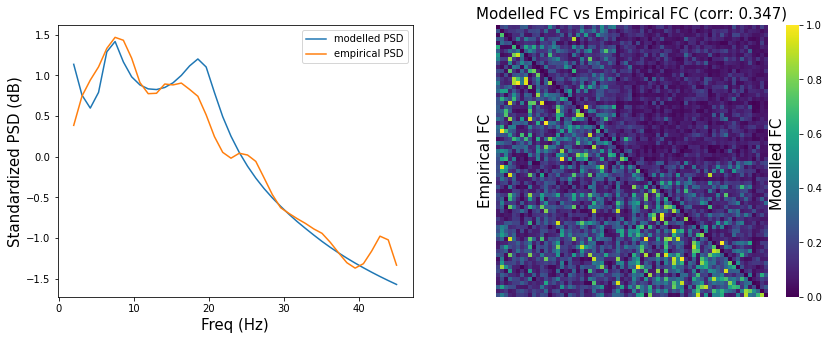

In [18]:
# compare your fitted one vs the empircal one
# type_: the results you want to show, "fc", "psd" or "both"
#        if None,  it shows plots depends on your fit_target
sbi_sgm.plot_compare(type_=None)

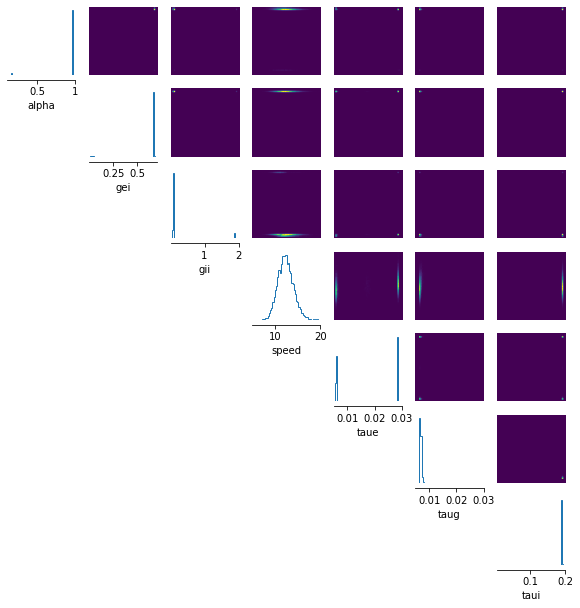

In [19]:
# the posterior density of sgm parameters
sbi_sgm.plot_pairdensity()